# Delivery ETA Prediction for Online Food Orders

In [110]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import het_breuschpagan
from sklearn.linear_model import LinearRegression
from scipy.stats import norm
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from numpy import sqrt
from datetime import timedelta

In [111]:
df = pd.read_csv('normalize_orders_data.csv')
driver = pd.read_excel('driver_schedule_data.xlsx')
weather = pd.read_excel('Weather.xlsx')

In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80282 entries, 0 to 80281
Data columns (total 32 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               80282 non-null  int64  
 1   customerid       80282 non-null  int64  
 2   status           80282 non-null  int64  
 3   created_at       80282 non-null  object 
 4   finished_at      80282 non-null  object 
 5   shop_id          80282 non-null  int64  
 6   grand_total      80282 non-null  float64
 7   subtotal         80282 non-null  float64
 8   tax              80282 non-null  float64
 9   shipping_tax     80282 non-null  float64
 10  shipping_amount  80282 non-null  float64
 11  discount_amount  80282 non-null  float64
 12  total_paid       80282 non-null  float64
 13  deliverytime     80282 non-null  object 
 14  type             80282 non-null  int64  
 15  order_type       80282 non-null  object 
 16  total_qty        80282 non-null  int64  
 17  distance    

In [113]:
df['city_name'] = df['city_id'].map({3613: 'Markham',
                                    3615: 'Mississauga',
                                    3149: 'North York',
                                    3614: 'Richmond Hill',
                                    3142: 'Toronto'})

#### Cook Time Per Restaurant

In [114]:
df['cook_time'] = (pd.to_datetime(df['cooked_at_adj']) - pd.to_datetime(df['confirm_at'])).dt.total_seconds()/60

In [115]:
cook_time = df.groupby(['shop_id'], as_index = False)['cook_time'].mean()

In [116]:
cook_time.head()

,shop_id,cook_time
0,15492,42.575000
1,15592,31.775000
2,15691,27.264493
3,15700,28.093243
4,15701,31.925000


#### Merging Transactional Orders Data with Driver Data

In [117]:
df['created_at_date'] = pd.to_datetime(df['created_at']).dt.date
driver['working_day'] = pd.to_datetime(driver['working_day']).dt.date

In [118]:
driver_availability = driver.groupby(['city_id', 'working_day'])['driver_id'].nunique()

In [119]:
driver_availability = driver_availability.reset_index()
driver_availability.rename(columns = {'driver_id' : 'Driver_Count'}, inplace = True)

In [120]:
driver_availability.head()

,city_id,working_day,Driver_Count
0,3142,2022-09-01,15
1,3142,2022-09-02,13
2,3142,2022-09-03,13
3,3142,2022-09-04,13
4,3142,2022-09-05,11


In [121]:
df = df.merge(driver_availability, how = 'left', left_on = ['city_id', 'created_at_date'], right_on = ['city_id', 'working_day'])

#### Merging Transactional Orders Data with Weather Data

In [122]:
weather.head()

,Month,Day,Temperature Avg,Avg Dew Point,Wind Speed (km/h) Avg
0,1,1,4.6,4.4,6.2
1,12,1,0.1,-5.1,34.1
2,12,2,5.0,-0.3,13.6
3,12,3,6.2,2.4,32.6
4,12,4,0.8,-5.8,26.4


In [123]:
df = df.merge(weather, how = 'left', left_on = ['month', pd.to_datetime(df['delivered_at']).dt.day], right_on = ['Month', 'Day'])

In [124]:
df.drop(['batch_group_no','status','type','shipping_type','done_status','cooked_at','confirm_at','assign_at','finished_at','grand_total','total_paid','order_type','deliverytime','cooked_at_adj'], axis = 1, inplace = True)

In [125]:
df.rename(columns = {'lead_time': 'delivery_lead_time'}, inplace = True)

In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80282 entries, 0 to 80281
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     80282 non-null  int64  
 1   customerid             80282 non-null  int64  
 2   created_at             80282 non-null  object 
 3   shop_id                80282 non-null  int64  
 4   subtotal               80282 non-null  float64
 5   tax                    80282 non-null  float64
 6   shipping_tax           80282 non-null  float64
 7   shipping_amount        80282 non-null  float64
 8   discount_amount        80282 non-null  float64
 9   total_qty              80282 non-null  int64  
 10  distance               80282 non-null  float64
 11  tips_amount            80282 non-null  float64
 12  city_id                80282 non-null  int64  
 13  pickup_at              80282 non-null  object 
 14  delivered_at           80282 non-null  object 
 15  de

In [127]:
df.head()

,id,customerid,created_at,shop_id,subtotal,tax,shipping_tax,shipping_amount,discount_amount,total_qty,...,city_name,cook_time,created_at_date,working_day,Driver_Count,Month,Day,Temperature Avg,Avg Dew Point,Wind Speed (km/h) Avg
0,13151258,3532557,2022-12-31 23:48:07,24508,15.99,2.60,0.52,3.99,0.0,1,...,North York,13.050000,2022-12-31,2022-12-31,16.0,12,1,0.1,-5.1,34.1
1,13151243,953735,2022-12-31 23:34:19,16227,6.85,1.41,0.52,3.99,6.0,1,...,North York,17.633333,2022-12-31,2022-12-31,16.0,12,31,7.0,6.8,10.9
2,13151215,3523652,2022-12-31 23:19:30,24508,15.99,2.60,0.52,3.99,0.0,1,...,North York,5.100000,2022-12-31,2022-12-31,16.0,12,1,0.1,-5.1,34.1
3,13151205,3333335,2022-12-31 23:14:57,29805,21.24,3.30,0.54,4.11,13.0,2,...,North York,27.183333,2022-12-31,2022-12-31,16.0,12,31,7.0,6.8,10.9
4,13151192,3608855,2022-12-31 23:04:24,22667,7.15,1.45,0.52,3.99,0.0,1,...,Toronto,0.050000,2022-12-31,2022-12-31,14.0,12,31,7.0,6.8,10.9


#### Feature Extraction - Hour of Order Creation

In [128]:
df['Hour_of_Order_Creation'] = pd.to_datetime(df['created_at'])

In [129]:
df['Hour_of_Order_Creation'] = [x.hour for x in df['Hour_of_Order_Creation']]

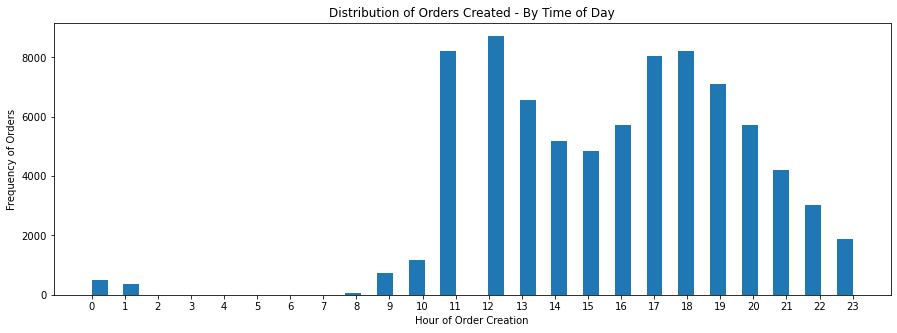

In [130]:
plt.figure(figsize = (15,5))
plt.hist(df['Hour_of_Order_Creation'], bins = 48)
plt.xlabel('Hour of Order Creation')
plt.ylabel("Frequency of Orders")
plt.xticks(np.arange(0,24,1))
plt.title('Distribution of Orders Created - By Time of Day')
plt.show()

In [131]:
idx = 0

for hour in df['Hour_of_Order_Creation']:
    
    if hour >= 6 and hour < 11:
        df.loc[idx, 'Rush_Hour_Orders'] = 0
    elif hour >= 10 and hour <= 14:
        df.loc[idx, 'Rush_Hour_Orders'] = 1
    elif hour > 16 and hour <= 20:
        df.loc[idx, 'Rush_Hour_Orders'] = 1
    else:
        df.loc[idx, 'Rush_Hour_Orders'] = 0
    
    idx += 1

#### Feature Extraction - Day of Order Creation

In [132]:
df['Day_of_Week'] = df['weekday'].map({0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday',
                                        5:'Saturday', 6:'Sunday'})

In [133]:
df['weekday_flag'] = np.where(df['weekday'] >= 5, 0, 1)

In [134]:
Day_Order_Creation = pd.get_dummies(df['Day_of_Week'], prefix = 'Order_Day', prefix_sep = '_', drop_first = True)

In [135]:
Day_Order_Creation.head()

,Order_Day_Monday,Order_Day_Saturday,Order_Day_Sunday,Order_Day_Thursday,Order_Day_Tuesday,Order_Day_Wednesday
0,0,1,0,0,0,0
1,0,1,0,0,0,0
2,0,1,0,0,0,0
3,0,1,0,0,0,0
4,0,1,0,0,0,0


In [136]:
df = df.merge(Day_Order_Creation, left_index = True, right_index = True)

In [137]:
df.head()

,id,customerid,created_at,shop_id,subtotal,tax,shipping_tax,shipping_amount,discount_amount,total_qty,...,Hour_of_Order_Creation,Rush_Hour_Orders,Day_of_Week,weekday_flag,Order_Day_Monday,Order_Day_Saturday,Order_Day_Sunday,Order_Day_Thursday,Order_Day_Tuesday,Order_Day_Wednesday
0,13151258,3532557,2022-12-31 23:48:07,24508,15.99,2.60,0.52,3.99,0.0,1,...,23,0.0,Saturday,0,0,1,0,0,0,0
1,13151243,953735,2022-12-31 23:34:19,16227,6.85,1.41,0.52,3.99,6.0,1,...,23,0.0,Saturday,0,0,1,0,0,0,0
2,13151215,3523652,2022-12-31 23:19:30,24508,15.99,2.60,0.52,3.99,0.0,1,...,23,0.0,Saturday,0,0,1,0,0,0,0
3,13151205,3333335,2022-12-31 23:14:57,29805,21.24,3.30,0.54,4.11,13.0,2,...,23,0.0,Saturday,0,0,1,0,0,0,0
4,13151192,3608855,2022-12-31 23:04:24,22667,7.15,1.45,0.52,3.99,0.0,1,...,23,0.0,Saturday,0,0,1,0,0,0,0


In [139]:
df['city_name'].value_counts()

North York       29488
Markham          22270
Toronto          18624
Richmond Hill     8402
Mississauga       1498
Name: city_name, dtype: int64

#### Restaurant Grouping - By First 2 Letters of Shop_ID & Distance

In [140]:
df['total_paid'] = df['subtotal'] + df['tax'] + df['shipping_amount'] + df['shipping_tax'] - df['discount_amount']

In [141]:
distance_q1 = df['distance'].quantile(0.25)
distance_q2 = df['distance'].quantile(0.5)
distance_q3 = df['distance'].quantile(0.75)

In [142]:
idx = 0

for distance in df['distance']:
    
    if distance <= distance_q1:
        df.loc[idx, 'distance_tier'] = 'Less_than_2_km'
    
    elif distance > distance_q1 and distance <= distance_q2:
        df.loc[idx, 'distance_tier'] = 'Within_2_3_km'
    
    elif distance > distance_q2 and distance <= distance_q3:
        df.loc[idx, 'distance_tier'] = 'Within_3_6_km'
    
    else:
        df.loc[idx, 'distance_tier'] = 'Greater_than_6_km'
        
    idx += 1

In [143]:
distance_levels = pd.get_dummies(df['distance_tier'], drop_first = True)

In [144]:
distance_levels.head()

,Less_than_2_km,Within_2_3_km,Within_3_6_km
0,0,1,0
1,1,0,0
2,0,1,0
3,1,0,0
4,0,1,0


In [145]:
df = df.merge(distance_levels, left_index = True, right_index = True)
# df.drop('Within_3_6_km', axis = 1, inplace = True)

In [146]:
df['shop_id_TWO'] = df['shop_id'].astype(str).str[0:2]

In [147]:
shop_id_With_TWO = pd.get_dummies(df['shop_id_TWO'], prefix = 'shop_id', prefix_sep = '_', drop_first = True)

In [148]:
df = df.merge(shop_id_With_TWO, left_index = True, right_index = True)

In [149]:
df.rename(columns = {'Temperature Avg': 'Temperature_Avg',
                    'Avg Dew Point ' : 'Avg_Dew_Point'}, inplace = True)

In [150]:
df['Weekday_Rush_Hour'] = df['Rush_Hour_Orders'] * df['weekday_flag']

In [151]:
df.columns

Index(['id', 'customerid', 'created_at', 'shop_id', 'subtotal', 'tax',
       'shipping_tax', 'shipping_amount', 'discount_amount', 'total_qty',
       'distance', 'tips_amount', 'city_id', 'pickup_at', 'delivered_at',
       'delivery_lead_time', 'weekday', 'month', 'city_name', 'cook_time',
       'created_at_date', 'working_day', 'Driver_Count', 'Month', 'Day',
       'Temperature_Avg', 'Avg_Dew_Point', 'Wind Speed (km/h) Avg',
       'Hour_of_Order_Creation', 'Rush_Hour_Orders', 'Day_of_Week',
       'weekday_flag', 'Order_Day_Monday', 'Order_Day_Saturday',
       'Order_Day_Sunday', 'Order_Day_Thursday', 'Order_Day_Tuesday',
       'Order_Day_Wednesday', 'total_paid', 'distance_tier', 'Less_than_2_km',
       'Within_2_3_km', 'Within_3_6_km', 'shop_id_TWO', 'shop_id_16',
       'shop_id_17', 'shop_id_18', 'shop_id_19', 'shop_id_20', 'shop_id_21',
       'shop_id_22', 'shop_id_23', 'shop_id_24', 'shop_id_25', 'shop_id_26',
       'shop_id_27', 'shop_id_28', 'shop_id_29', 'shop_id_3

#### Final Model

In [152]:
# plot_columns = [
    
# # Order Time
#        'Rush_Hour_Orders',

# # # Day of Order Creation
# #        'Order_Day_Monday', 
# #        'Order_Day_Saturday',
# #        'Order_Day_Sunday', 
# #        'Order_Day_Thursday', 
# #        'Order_Day_Tuesday',
# #        'Order_Day_Wednesday',
# #        'weekday_flag', 
# #        'Weekday_Rush_Hour',

# # Destination Attributes
#      'distance', 

# # Order Attributes
# #     'tips_amount',
# #     'total_paid', 
# #      'total_qty', 
    
# # Driver Availability
#          'Driver_Count', 
#         'Less_than_2_km',
#         'Within_2_3_km',
#         'Within_3_6_km',
    
# # Shop_ID Attributes  
# #        'shop_id_16', 'shop_id_17', 'shop_id_18', 'shop_id_19',
# #        'shop_id_20', 'shop_id_21', 'shop_id_22', 'shop_id_23', 'shop_id_24',
# #        'shop_id_25', 'shop_id_26', 'shop_id_27', 'shop_id_28', 'shop_id_29',
# #        'shop_id_30', 'shop_id_31', 'shop_id_32',
    
# #Weather
#     'Temperature_Avg', 
#     'Avg_Dew_Point' #, 'Wind_Speed_km_h_Avg'
    
# ]

# plt.figure(figsize=(6, 5))
# heatmap = sns.heatmap(df[plot_columns].corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
# heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);
# plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')

In [153]:
modelling_columns = [
    
# Order Time
       'Rush_Hour_Orders',

# # Day of Order Creation
#        'Order_Day_Monday', 
#        'Order_Day_Saturday',
#        'Order_Day_Sunday', 
#        'Order_Day_Thursday', 
#        'Order_Day_Tuesday',
#        'Order_Day_Wednesday',
#        'weekday_flag', 
#        'Weekday_Rush_Hour',

# Destination Attributes
     'distance', 

# Order Attributes
#     'tips_amount',
#     'total_paid', 
#      'total_qty', 
    
# Driver Availability
         'Driver_Count', 
        'Less_than_2_km',
        'Within_2_3_km',
        'Within_3_6_km',

# Shop_ID Attributes  
       'shop_id_16', 'shop_id_17', 'shop_id_18', 'shop_id_19',
       'shop_id_20', 'shop_id_21', 'shop_id_22', 'shop_id_23', 'shop_id_24',
       'shop_id_25', 'shop_id_26', 'shop_id_27', 'shop_id_28', 'shop_id_29',
       'shop_id_30', 'shop_id_31', 'shop_id_32',
    
#Weather
     'Temperature_Avg', 
     'Avg_Dew_Point'
#     , 'Wind_Speed_km_h_Avg'
    
]

df_oct_3615 = df[(df['month'] == 10)  & (df['city_id'] == 3615)]

initial_string = 'delivery_lead_time ~ '

for idx in range(len(modelling_columns)): 
    
    if idx != len(modelling_columns)-1:
        new_string = initial_string + modelling_columns[idx] + ' + '
    else:
        new_string = initial_string + modelling_columns[idx]

    initial_string = new_string

print(new_string)
input_to_ols = new_string

initial_model = ols(input_to_ols, df_oct_3615).fit()
initial_model.summary()

delivery_lead_time ~ Rush_Hour_Orders + distance + Driver_Count + Less_than_2_km + Within_2_3_km + Within_3_6_km + shop_id_16 + shop_id_17 + shop_id_18 + shop_id_19 + shop_id_20 + shop_id_21 + shop_id_22 + shop_id_23 + shop_id_24 + shop_id_25 + shop_id_26 + shop_id_27 + shop_id_28 + shop_id_29 + shop_id_30 + shop_id_31 + shop_id_32 + Temperature_Avg + Avg_Dew_Point


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     delivery_lead_time   R-squared:                       0.224
Model:                            OLS   Adj. R-squared:                  0.177
Method:                 Least Squares   F-statistic:                     4.754
Date:                Sat, 22 Apr 2023   Prob (F-statistic):           1.60e-10
Time:                        23:55:21   Log-Likelihood:                -1552.0
No. Observations:                 367   AIC:                             3148.
Df Residuals:                     345   BIC:                             3234.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           22.7622      6.812      3.341      0.001       9.363      36.161
Rush_Hour_Orders    -3.6618      2.512     -1.458      0.146      -8.603       1.280
distance             1.2709      0.561      2.264      0.024       0.167       2.375
Driver_Count         1.2982      1.686      0.770      0.442      -2.017       4.614
Less_than_2_km      -7.6202      5.246     -1.453      0.147     -17.937       2.697
Within_2_3_km       -4.9933      4.993     -1.000      0.318     -14.814       4.827
Within_3_6_km       -0.9291      3.241     -0.287      0.775      -7.304       5.446
shop_id_16          -2.3682      3.190     -0.742      0.458      -8.642       3.906
shop_id_17          -0.1554      2.757     -0.056      0.955      -5.578       5.267
shop_id_18        3.472e-15   7.45e-15      0.466      0.642   -1.12e-14    1.81e-14
shop_id_19          16.1709      4.992      3.239      0.001       6.352      25.990
shop_id_20         -10.3472     11.557     -0.895      0.371     -33.079      12.384
shop_id_21          14.2863      8.227      1.737      0.083      -1.894      30.467
shop_id_22          -7.6172      5.634     -1.352      0.177     -18.699       3.464
shop_id_23          -6.0424      4.248     -1.423      0.156     -14.397       2.312
shop_id_24          -2.6743      4.849     -0.552      0.582     -12.211       6.863
shop_id_25           8.2575     16.187      0.510      0.610     -23.581      40.096
shop_id_26         1.05e-15   1.96e-15      0.535      0.593   -2.81e-15    4.91e-15
shop_id_27          -3.7425      3.668     -1.020      0.308     -10.957       3.472
shop_id_28       -2.646e-16   9.79e-16     -0.270      0.787   -2.19e-15    1.66e-15
shop_id_29          -1.5044      2.467     -0.610      0.542      -6.357       3.349
shop_id_30           7.9916      3.675      2.175      0.030       0.763      15.220
shop_id_31           6.5952      2.859      2.307      0.022       0.973      12.218
shop_id_32           3.9123      4.119      0.950      0.343      -4.190      12.015
Temperature_Avg     -0.9310      0.525     -1.774      0.077      -1.963       0.101
Avg_Dew_Point        1.1208      0.462      2.425      0.016       0.212       2.030
==============================================================================
Omnibus:                       95.638   Durbin-Watson:                   1.877
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              191.305
Skew:                           1.385   Prob(JB):                     2.88e-42
Kurtosis:                       5.199   Cond. No.                     1.31e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.04e-30. Thi

#### Model Evaluation for All City / Month Combinations

In [154]:
months = [9, 10, 11, 12]

In [158]:
cities = ['Markham', 'Mississauga', 'North York', 'Richmond Hill', 'Toronto']

In [173]:
results = []

for month in months:
    for city in cities:
        
        df_city = df[df['city_name'] == city]
        df_month_city = df_city[df_city['month'] == month]
        
        df_month_city = df_month_city.fillna(0)
                
        train_X = df_month_city[modelling_columns].values
        train_y = df_month_city['delivery_lead_time'].values
    
        reg_model = LinearRegression().fit(train_X, train_y)
        
        X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, train_size=0.7, random_state=0)
        
        #Calculating some evaluation metrics for the linear regression model
        
        R_Squared = round(reg_model.score(train_X, train_y),2)
        Training_RMSE = round(sqrt(mean_squared_error(y_train, reg_model.predict(X_train))),2)
        Training_MAE = round(mean_absolute_error(y_train, reg_model.predict(X_train)),2)
        Testing_RMSE = round(sqrt(mean_squared_error(y_test, reg_model.predict(X_test))),2)
        Testing_MAE = round(mean_absolute_error(y_test, reg_model.predict(X_test)),2)
        
        initial_string = 'delivery_lead_time ~ '

        for idx in range(len(modelling_columns)): 

            if idx != len(modelling_columns)-1:
                new_string = initial_string + modelling_columns[idx] + ' + '
            else:
                new_string = initial_string + modelling_columns[idx]

            initial_string = new_string
        
        input_to_ols = new_string
        initial_model = ols(input_to_ols, df_month_city).fit()
        
        model_output = pd.DataFrame(initial_model.predict(df_month_city[modelling_columns]))
        final_output = df_month_city.merge(model_output, how = 'inner', left_index = True, right_index = True)
        final_output.rename(columns = {0: 'Predicted_Lead_Time'}, inplace = True)

        delivery_buffer = 15
        final_output['Total_ETA'] = final_output['cook_time'] + final_output['Predicted_Lead_Time']
        final_output['Total_ETA_with_Buffer'] = final_output['cook_time'] + final_output['Predicted_Lead_Time'] + delivery_buffer

        final_output['Actual_ETA'] = (pd.to_datetime(final_output['delivered_at']) - pd.to_datetime(final_output['created_at'])).dt.total_seconds()/60
        final_output['ETA_given_to_Customer'] = pd.to_datetime(final_output['created_at']) + pd.to_timedelta(round(final_output['Total_ETA_with_Buffer'],2), unit='m')

        final_output['On_Time_Without_Model'] = [1 if minutes <= 45 else 0 for minutes in final_output['Actual_ETA']]

        final_output['On_Time_With_Model'] = 0
        final_output['On_Time_With_Model_With_15_Min_Buffer'] = 0
        
        idx = 0

        for idx in range(0, len(final_output)):

            if final_output.iloc[idx, 64] < final_output.iloc[idx, 65]:
                final_output.iloc[idx, 69] = 0
            else:
                final_output.iloc[idx, 69] = 1

            idx += 1
        
        
        idx_1 = 0
        
        for idx_1 in range(0, len(final_output)):
            
            if final_output.iloc[idx_1, 63] < final_output.iloc[idx_1, 65]:
                 final_output.iloc[idx_1, 68] = 0
            else:
                final_output.iloc[idx_1, 68] = 1

            idx_1 += 1
            

        on_time_without_model = round(sum(final_output['On_Time_Without_Model']) / len(final_output['On_Time_Without_Model']) * 100, 2)
        on_time_with_model = round(sum(final_output['On_Time_With_Model']) / len(final_output['On_Time_With_Model']) * 100, 2)
        on_time_with_model_15_min_buffer = round(sum(final_output['On_Time_With_Model_With_15_Min_Buffer']) / len(final_output['On_Time_With_Model_With_15_Min_Buffer']) * 100, 2)
                
        results.append([month, city, R_Squared, Training_RMSE, Training_MAE, Testing_RMSE, Testing_MAE,
                       on_time_without_model, on_time_with_model, on_time_with_model_15_min_buffer])
                
results = pd.DataFrame(results)
results = results.rename(columns = {0:'Month', 
                                   1:'City',
                                   2:'R-Squared',
                                   3:'Training_RMSE',
                                   4:'Training_MAE',
                                   5:'Testing_RMSE',
                                   6:'Testing_MAE',
                                   7:'On Time % Without Model',
                                   8:'On Time % With Model',
                                   9:'On Time % With Model With 15 Min Buffer'})

results.sort_values(by = 'City')

,Month,City,R-Squared,Training_RMSE,Training_MAE,Testing_RMSE,Testing_MAE,On Time % Without Model,On Time % With Model,On Time % With Model With 15 Min Buffer
0,9,Markham,0.16,17.16,13.35,16.93,13.31,40.94,61.39,84.68
5,10,Markham,0.12,19.53,15.42,19.22,15.41,35.83,60.24,81.82
10,11,Markham,0.12,20.38,16.22,20.15,15.88,34.17,60.60,80.74
15,12,Markham,0.16,18.50,14.63,18.96,14.89,42.05,59.69,82.45
1,9,Mississauga,0.22,16.64,12.60,13.84,10.34,42.90,58.47,81.97
6,10,Mississauga,0.22,17.21,12.73,15.50,11.70,34.73,59.53,83.29
11,11,Mississauga,0.25,15.03,10.92,13.69,10.49,42.12,56.07,84.50
16,12,Mississauga,0.23,17.95,13.65,19.53,14.37,32.60,54.97,81.49
2,9,North York,0.21,15.97,12.44,15.77,12.17,52.34,57.77,83.70
17,12,North York,0.18,17.75,13.71,17.08,13.29,54.57,59.45,83.19


#### Utilizing Model Output

In [174]:
def month_city_model_output(month, city, df, delivery_buffer):
    
    df_city = df[df['city_name'] == city]
    df_month_city = df_city[df_city['month'] == month]
        
    df_month_city = df_month_city.fillna(0)
                
    train_X = df_month_city[modelling_columns].values
    train_y = df_month_city['delivery_lead_time'].values
        
    initial_string = 'delivery_lead_time ~ '

    for idx in range(len(modelling_columns)): 

        if idx != len(modelling_columns)-1:
            new_string = initial_string + modelling_columns[idx] + ' + '
        else:
            new_string = initial_string + modelling_columns[idx]

        initial_string = new_string
        
    input_to_ols = new_string
    initial_model = ols(input_to_ols, df_month_city).fit()
        
    model_output = pd.DataFrame(initial_model.predict(df_month_city[modelling_columns]))
    final_output = df_month_city.merge(model_output, how = 'inner', left_index = True, right_index = True)
    final_output.rename(columns = {0: 'Predicted_Lead_Time'}, inplace = True)

    delivery_buffer = 15
    final_output['Total_ETA'] = final_output['cook_time'] + final_output['Predicted_Lead_Time']
    final_output['Total_ETA_with_Buffer'] = final_output['cook_time'] + final_output['Predicted_Lead_Time'] + delivery_buffer

    final_output['Actual_ETA'] = (pd.to_datetime(final_output['delivered_at']) - pd.to_datetime(final_output['created_at'])).dt.total_seconds()/60
    final_output['ETA_given_to_Customer'] = pd.to_datetime(final_output['created_at']) + pd.to_timedelta(round(final_output['Total_ETA_with_Buffer'],2), unit='m')

    final_output['On_Time_Without_Model'] = [1 if minutes <= 45 else 0 for minutes in final_output['Actual_ETA']]

    final_output['On_Time_With_Model'] = 0
    final_output['On_Time_With_Model_With_15_Min_Buffer'] = 0
        
    idx = 0

    for idx in range(0, len(final_output)):

        if final_output.iloc[idx, 64] < final_output.iloc[idx, 65]:
            final_output.iloc[idx, 69] = 0
        else:
            final_output.iloc[idx, 69] = 1

        idx += 1
        
        
    idx_1 = 0
        
    for idx_1 in range(0, len(final_output)):
            
        if final_output.iloc[idx_1, 63] < final_output.iloc[idx_1, 65]:
             final_output.iloc[idx_1, 68] = 0
        else:
            final_output.iloc[idx_1, 68] = 1

        idx_1 += 1
    
    return final_output

In [175]:
model_output = []

for month in months:
    for city in cities:
        temp_model_output = pd.DataFrame(month_city_model_output(month, city, df, 15))
        model_output.append(temp_model_output)    

model_output = pd.concat(model_output)

In [176]:
model_output.head()

,id,customerid,created_at,shop_id,subtotal,tax,shipping_tax,shipping_amount,discount_amount,total_qty,...,shop_id_32,Weekday_Rush_Hour,Predicted_Lead_Time,Total_ETA,Total_ETA_with_Buffer,Actual_ETA,ETA_given_to_Customer,On_Time_Without_Model,On_Time_With_Model,On_Time_With_Model_With_15_Min_Buffer
62960,12869984,3508673,2022-09-30 23:48:08,16510,62.50,9.04,0.91,6.99,10.59,4,...,0,0.0,18.411801,28.295134,43.295134,38.900000,2022-10-01 00:31:26.000,1,0,1
62964,12869972,3592530,2022-09-30 23:39:57,18824,28.98,4.54,0.77,5.89,6.28,2,...,0,0.0,20.637310,58.770643,73.770643,45.266667,2022-10-01 00:53:43.200,0,1,1
62965,12869963,3660235,2022-09-30 23:35:54,20875,29.80,4.65,0.78,5.97,0.00,4,...,0,0.0,32.913717,85.113717,100.113717,61.933333,2022-10-01 01:16:00.600,0,1,1
62974,12869895,825977,2022-09-30 22:54:53,17088,36.98,5.68,0.87,6.69,0.00,2,...,0,0.0,29.029553,58.596219,73.596219,56.916667,2022-10-01 00:08:29.000,0,1,1
62979,12869847,3599839,2022-09-30 22:18:55,17613,23.90,3.42,0.31,2.39,2.70,2,...,0,0.0,35.074230,58.174230,73.174230,95.500000,2022-09-30 23:32:05.200,0,0,0


#### Overall Ontime Performance

In [177]:
on_time_performance_without_model = round(sum(model_output['On_Time_Without_Model'])/len(model_output) * 100, 2)
on_time_performance_with_model = round(sum(model_output['On_Time_With_Model'])/len(model_output) * 100, 2)
on_time_performance_with_model_with_buffer = round(sum(model_output['On_Time_With_Model_With_15_Min_Buffer'])/len(model_output) * 100, 2)

print('Overall On Time Performance Without Model: ', on_time_performance_without_model, '%')
print('Overall On Time Performance With Model: ', on_time_performance_with_model, '%')
print('Overall On Time Performance With Model With 15 minute Buffer: ', on_time_performance_with_model_with_buffer, '%')

Overall On Time Performance Without Model:  45.22 %
Overall On Time Performance With Model:  58.43 %
Overall On Time Performance With Model With 15 minute Buffer:  82.48 %


In [185]:
ontime_performance_by_distance = model_output.groupby(['distance_tier'], as_index = False)[['On_Time_Without_Model', 'On_Time_With_Model', 'On_Time_With_Model_With_15_Min_Buffer' ]].mean()
ontime_performance_by_distance['On_Time_Without_Model'] *= 100
ontime_performance_by_distance['On_Time_With_Model'] *= 100
ontime_performance_by_distance['On_Time_With_Model_With_15_Min_Buffer'] *= 100

ontime_performance_by_distance

,distance_tier,On_Time_Without_Model,On_Time_With_Model,On_Time_With_Model_With_15_Min_Buffer
0,Greater_than_6_km,28.459840,55.091413,79.136243
1,Less_than_2_km,61.921337,61.414704,85.392737
2,Within_2_3_km,44.138579,59.285618,83.342285
3,Within_3_6_km,39.731980,57.025247,81.156239


In [183]:
model_output.to_excel('Model_Output.xlsx')